# Synthesizing Anomalies with Autoencoders

This proposed methods utilizes an overfitted autoencoder model to synthesize anomalies. This procedure is in line with the principles discussed in the paper Systematic Construction of Anomaly Detection Benchmarks from Real Data (Emmott et. al.).

In [1]:
%matplotlib inline

# Import necessary libraries
import sys
sys.path.append("../pyanomaly/lib")
from deep_autoencoder import DeepAutoencoder

import pandas as pd
import random
import numpy as np

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Utility method to sample values on tail ends of a distribution given mean and standard deviation
# n refers to the number of samples generated
def sample_tails(mu, sig, n=1000):
    samples = np.array(sorted(np.random.normal(mu, sig, n)))
    q1, q3 = np.percentile(samples, [25, 75])
    iqr = q3 - q1
    
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    
    return np.concatenate((samples[samples < lower_bound], samples[samples > upper_bound]))

In [2]:
# The configuration for the autoencoder
config = {
    "input_size": 11,
    "o_activation": "sigmoid",
    "h_activation": "relu",
    "optimizer": {
        "name": "adam",
        "learning_rate": 0.001,
        "momentum": 0.0,
        "decay": 0.0
    },
    "encoding_layers": [
        { "size": 9, "activation": "relu", "bias": 1.0 },
        { "size": 5, "activation": "relu", "bias": 1.0 }
    ],
    "decoding_layers": [
        { "size": 9, "activation": "relu", "bias": 1.0 },
        { "size": 11, "activation": "sigmoid", "bias": 1.0 }
    ],
    "epochs": 5,
    "loss": "mse",
    "bias": 1.0,
    "batch_size": 10
}

autoencoder = DeepAutoencoder(config)
autoencoder.compile()
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 5)                 60        
_________________________________________________________________
sequential_1 (Sequential)    (None, 11)                66        
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 60        
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)   

## Training

Train the autoencoder model.

In [3]:
input_file = "../pyanomaly/data/magic04_normalized_gamma.csv"
input_data = pd.read_csv(input_file)
input_data_no_labels = input_data.drop(['y'], axis=1)

autoencoder.train(input_data_no_labels)

Epoch 1/5
1234/1234 [==============================] - 5s 4ms/step - loss: 0.0397 - acc: 0.8722
Epoch 2/5
1234/1234 [==============================] - 5s 4ms/step - loss: 0.0081 - acc: 0.9997
Epoch 3/5
1234/1234 [==============================] - 5s 4ms/step - loss: 0.0030 - acc: 0.9997
Epoch 4/5
1234/1234 [==============================] - 4s 4ms/step - loss: 0.0019 - acc: 0.9997
Epoch 5/5
1234/1234 [==============================] - 4s 4ms/step - loss: 0.0015 - acc: 0.9997


## Encoding and Latent Parameters

Create a dataset corresponding to the encoded version of the input data. Create vector of distribution parameters based on encoded data.

In [4]:
encoded_data = autoencoder.encode(input_data_no_labels)
df_encoded_data = pd.DataFrame(data=encoded_data)
df_encoded_data_mean = df_encoded_data.mean(axis=0)
df_encoded_data_std = df_encoded_data.std(axis=0)
predicted_data = autoencoder.predict(input_data_no_labels)
print("Encoded Data Mean")
print(df_encoded_data_mean)
print("Encoded Data Standard Deviation")
print(df_encoded_data_std)

Encoded Data Mean
0    1.884778
1    2.983861
2    0.014881
3    1.399344
4    1.927909
dtype: float32
Encoded Data Standard Deviation
0    0.784928
1    0.268202
2    0.035658
3    0.383655
4    0.527703
dtype: float32


## Sampling Anomalous Data
From mean and std of encoded data, randomly select x dimensions and sample from their tail ends. Dimensions that do not belong to x will use sampled data from the original encoded set. 

For example, if we set `stochastic_dimension_count` to `5` it means we randomly select `5` dimensions from the encoded vector's dimensionality and sample tail end values from a nomral distrubution of those `5` dimensions. The remaining dimensions' values will be sampled randomly from existing data in `df_encoded_data`.

The intuition is to create encoded data that is sampled from latent space based on the "oracle" (in this case, the autoencoder). This captures the relevant information as computed by the neural network.

### Relative Frequency

According to the paper, relative frequency `K` is the ratio of anomalous datapoints existing in a dataset. Example values would be `0.001`, `0.01`, `0.1`. In terms of sampling, we synthesize `K * num_datapoints` anomalous datapoints.

In [5]:
stochastic_dimension_count = 1
stochastic_dimensions = random.sample(range(len(df_encoded_data.columns)), stochastic_dimension_count)

relative_frequency = 0.01
num_datapoints = len(input_data.index)
num_to_synthesize = round(relative_frequency * num_datapoints)
sampled_original = (df_encoded_data.sample(num_to_synthesize)).reset_index(drop=True)

# Loop through each sampled_original and sample a tail end for each dimension in stohastic_dimensions

synthetic_data = sampled_original.copy()

for index, row in synthetic_data.iterrows():
    for d in stochastic_dimensions:
        tail_values = sample_tails(df_encoded_data_mean.values[d], df_encoded_data_std.values[d], 10000)
        sampled_outlier_feature = random.choice(tail_values)
        synthetic_data.at[index, d] = sampled_outlier_feature

print("Stochastic Dimensions:")
print(stochastic_dimensions)
print("Number of datapoints:", num_datapoints)
print("Number of anomalous points to synthesize:", num_to_synthesize)
print("Sampled Original:")
print(sampled_original)

print("Synthetic Data:")
print(synthetic_data)

print(synthetic_data - sampled_original)

Stochastic Dimensions:
[0]
Number of datapoints: 12332
Number of anomalous points to synthesize: 123
Sampled Original:
            0         1         2         3         4
0   -0.000000  3.296157 -0.000000  1.433114  1.950876
1    2.314263  2.730750  0.049999  1.669931  1.658796
2    2.674636  2.695179  0.075322  0.994847  1.448879
3    1.948454  3.079157 -0.000000  1.331855  2.291927
4    2.416913  2.790481  0.005069  1.688791  1.778478
..        ...       ...       ...       ...       ...
118  1.011183  3.182142 -0.000000  1.313083  2.146254
119  0.714351  3.257530 -0.000000  1.397140  2.222034
120  0.151149  3.276326 -0.000000  1.433339  2.367555
121  2.595680  2.786963  0.074119  1.627714  1.897181
122  1.334102  3.556354 -0.000000  0.631604  2.604925

[123 rows x 5 columns]
Synthetic Data:
            0         1         2         3         4
0    4.028307  3.296157 -0.000000  1.433114  1.950876
1    4.148721  2.730750  0.049999  1.669931  1.658796
2   -0.273841  2.695179  0.0753

### Synthesize Anomalous Data Points
To synthesize anomalous datapoints, we decode the synthetic data and map it back to its original dimensionality using the trained weights from the original autoencoder.

In [6]:
original_datapoints = input_data_no_labels.values
reconstructed_datapoints = autoencoder.decode(encoded_data)
synthesized_datapoints = autoencoder.decode(synthetic_data)

original_length = len(original_datapoints)
reconstructed_length = len(reconstructed_datapoints)
synthesized_length = len(synthesized_datapoints)

print("Original Lengt:", original_length)
print("Reconstructed Length:", reconstructed_length)
print("Synthesized Length:", synthesized_length)

Original Lengt: 12332
Reconstructed Length: 12332
Synthesized Length: 123


## Visualization
Visualize the data using TSNE

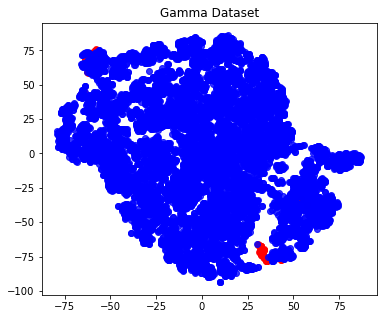

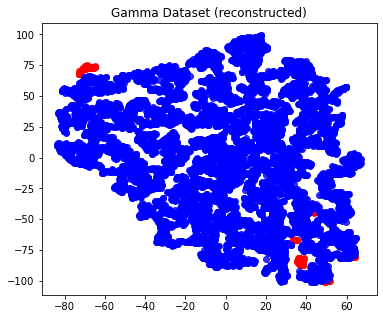

In [7]:
# Create a dataframe with labels 0 for normal data and 1 for anomalous data
anomalous_data_labels = np.ones((synthesized_length, 1))
original_data_labels = np.zeros((original_length, 1))

anomalous_data_with_labels = np.append(synthesized_datapoints, anomalous_data_labels, axis=1)
original_data_with_labels = np.append(original_datapoints, original_data_labels, axis=1)
reconstructed_data_with_labels = np.append(reconstructed_datapoints, original_data_labels, axis=1)

X = np.concatenate((anomalous_data_with_labels, original_data_with_labels))
X_r = np.concatenate((anomalous_data_with_labels, reconstructed_data_with_labels))

tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(np.delete(X, np.s_[-1:], axis=1))
X_2d_r = tsne.fit_transform(np.delete(X_r, np.s_[-1:], axis=1))

plt.figure(figsize=(6,5))
plt.title("Gamma Dataset")
plt.scatter(X_2d[0:(synthesized_length - 1),0], X_2d[0:(synthesized_length - 1),1], c='r', label='Normal', alpha=0.8)
plt.scatter(X_2d[(synthesized_length):-1,0], X_2d[(synthesized_length):-1,1], c='b', label='Normal', alpha=0.8)

plt.figure(figsize=(6,5))
plt.title("Gamma Dataset (reconstructed)")
plt.scatter(X_2d_r[0:(synthesized_length - 1),0], X_2d_r[0:(synthesized_length - 1),1], c='r', label='Normal', alpha=0.8)
plt.scatter(X_2d_r[(synthesized_length):-1,0], X_2d_r[(synthesized_length):-1,1], c='b', label='Normal', alpha=0.8)

### 